# Acquisition des données de composés
Objectif : Acquérir des données de composés testé sur une cible thérapeutique spécifique.
## Prérequis
Importation des modules nécessaires : 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit
!pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 52.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 60 kB 6.6 MB/s 
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.1.2 which is incompatible.


In [ ]:
import math
import numpy as np
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

## Récupération de la protéine sur la base de données ChEMBL

In [ ]:
# Préparation de l'api pour accéder à la base de donnée ChEMBL
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity


# Protéine à étudier : MET
# identifiant uniprot : P08581
#uniprot_id = "P00533"
uniprot_id = "P08581"
# Enrergistrement du code uniprot de la cible dans un fichier texte
with open("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/01_compoundDataAcquisition/uniprot_id.txt", "wb") as file:
    pickle.dump(uniprot_id, file)
# Récupération des informations sur la protéine à partir de la base de donnée ChEMBL
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
# La protéine d'intérêt est la première entrée du dataframe
target = targets.iloc[0]
## Enregistrement de son chemblID
chembl_id = target.target_chembl_id

## Récupération et traitement des données d'essais d'IC50

In [ ]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)
# Téléchargement
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"Nombre de données de d'essais d'IC50: {bioactivities_df.shape[0]}")

Nombre de données de d'essais d'IC50: 4206


In [ ]:
# Traitement des données d'essais d'IC50
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
# Conversition du type de donnée
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
# Suppression des lignes avec des données manquantes
bioactivities_df.dropna(axis=0, how="any", inplace=True)
# Sélection uniquement des lignes pour lesquelles l'unité est en nM
bioactivities_df = bioactivities_df[bioactivities_df.standard_units == "nM"]
# Suppression des duplicatas dans les molécules
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
# Remise à zéro des index du jeu de données
bioactivities_df.reset_index(drop=True, inplace=True)
# Renommage de certains noms de colonnes
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
print(f"Le jeu de donnée final comporte {bioactivities_df.shape[0]} composés.")

Le jeu de donnée final comporte 3204 composés.


## Récupération d'informations concernant les composés testés

In [ ]:
# Récupération des informations des molécules
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

compounds = list(tqdm(compounds_provider))
compounds_df = pd.DataFrame.from_records(
    compounds,
)
# Suppression des lignes avec une donnée manquante
compounds_df.dropna(axis=0, how="any", inplace=True)
# Suppression des lignes dupliquées
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
# Récupération uniquement de la strucutre sous la forme SMILES
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
# Suppression des molécules sans structure SMILES
compounds_df.dropna(axis=0, how="any", inplace=True)

  0%|          | 0/3204 [00:00<?, ?it/s]

## Fusion des deux jeux de données

In [ ]:
# Création d'une fonction qui converti l'IC50 en pIC50
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [ ]:
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Remise à zéro des index
output_df.reset_index(drop=True, inplace=True)
# Création d'une colonne pour la pIC50
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
# Rangement du jeu de données selon la valeur de la pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

In [ ]:
output_df.pIC50.describe()

count    3204.000000
mean        7.247326
std         1.119010
min         3.585027
25%         6.505633
50%         7.431798
75%         8.077145
max         9.886057
Name: pIC50, dtype: float64

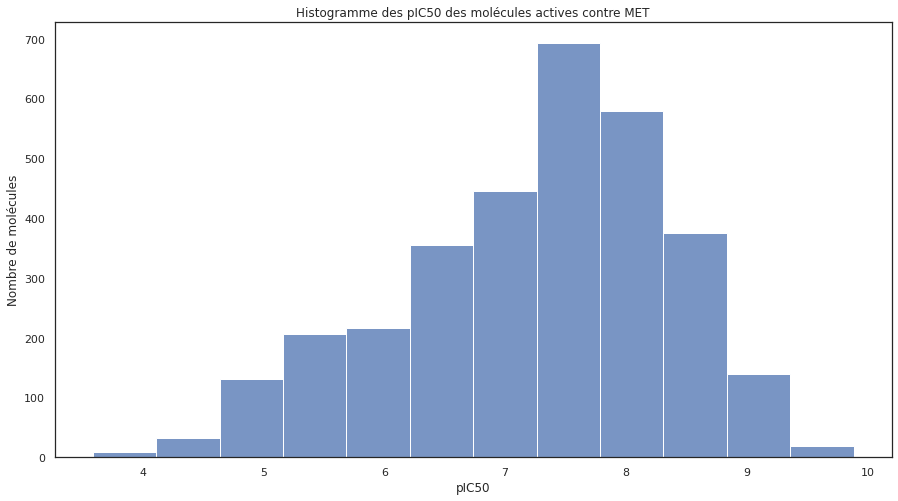

In [37]:
sns.set_style("white")
fig = sns.histplot(output_df, x="pIC50",bins = int(1+3.322*np.log10(output_df.shape[0])))
fig.set(xlabel="pIC50", ylabel="Nombre de molécules")
plt.title("Histogramme des pIC50 des molécules actives contre MET")
plt.show()

## Enregistrement du jeu de données

In [ ]:
#output_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/these_exercice/output/01_compoundDataAcquisition/{uniprot_id}_compounds.csv", index=False)